In [1]:
import pandas as pd
import json

In [2]:
dataset_dir = "../../datasets/processed/Combined_Dataset.csv"
df = pd.read_csv(dataset_dir)

In [3]:
def get_match_info(match_df_idx):
    return {
        "Match_ID": df.iloc[match_df_idx]['MatchID'],
        "Home": df.iloc[match_df_idx]['Home'],
        "Away": df.iloc[match_df_idx]['Away'],
        "Preview": df.iloc[match_df_idx]['Text'],
        "Season": df.iloc[match_df_idx]['Season'],
    }

In [4]:
sentiment_analysis_dir = f"../../nlp/match_outcome_sentiment_analysis/output/sentiment-analysis_gpt-4o-mini_prompt-v3.json"
sentiment_analysis_json = json.load(open(sentiment_analysis_dir))

In [5]:
home_bias_value = 0.5
draw_range = 0.3

In [6]:
predictions = []
game_results = []

for idx, row in df.iterrows():

    # Get the match info
    match_info = get_match_info(idx)
    match_id = match_info['Match_ID']
    
    # Get the sentiment analysis for the match
    match_sentiments = sentiment_analysis_json.get(str(match_id), [])
    match_sentiments = [int(sentiment) for sentiment in match_sentiments]


    if match_sentiments:
        avg_sentiment = sum(match_sentiments) / len(match_sentiments)
    else:
        print(f"No sentiment data for df idx '{idx}', match '{match_id}'")
        continue

    # Get the match prediction
    if avg_sentiment < 3 + home_bias_value - draw_range/2:      # Predicted home win
        prediction = 0
    elif avg_sentiment > 3 + home_bias_value + draw_range/2:    # Predicted away win
        prediction = 1
    else:                                                       # Predicted draw
        prediction = 2

    # Get the actual match result
    if row['FTR'] == 'H':       # Home win
        game_result = 0
    elif row['FTR'] == 'A':     # Away win
        game_result = 1
    elif row['FTR'] == 'D':     # Draw
        game_result = 2
    else:
        print(f"Result data ({row['FTR']=}) not valid ('H', 'A', or 'D') for df idx '{idx}', match id '{match_id}'")
        continue

    predictions.append(prediction)
    game_results.append(game_result)

In [7]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(game_results, predictions)
print(f"Accuracy of sentiment analysis predictions: {accuracy * 100:.2f}%")

Accuracy of sentiment analysis predictions: 50.52%


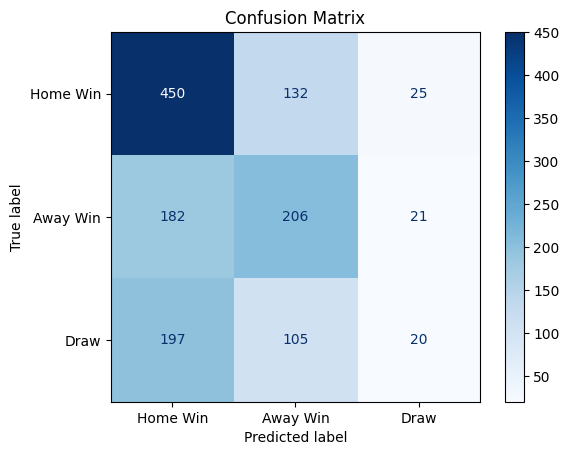

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(game_results, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Home Win', 'Away Win', 'Draw'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

# Prepare the data
X = [sum([int(sentiment) for sentiment in sentiment_analysis_json.get(str(match_id), [])]) / len(sentiment_analysis_json.get(str(match_id), [])) if sentiment_analysis_json.get(str(match_id), []) else 0 for match_id in df['MatchID']]
X = [[x] for x in X]
scaler = MinMaxScaler()
X = scaler.fit_transform(X).flatten()
y = [0 if result == 'H' else 1 if result == 'D' else 2 for result in df['FTR']]

# Split the data into training/validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Perform cross-validation on the training set
cross_val_scores = cross_val_score(model, [[x] for x in X_train], y_train, cv=5)
print(f"Cross-validation accuracy: {cross_val_scores.mean() * 100:.2f}%")

# Train the model on the entire training set
model.fit([[x] for x in X_train], y_train)

# Evaluate the model on the test set
y_pred = model.predict([[x] for x in X_test])
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {test_accuracy * 100:.2f}%")

home_wins = y_train.count(0)
draws = y_train.count(1)
away_wins = y_train.count(2)

total = len(y_train)

print(f"Home wins: {home_wins / total * 100:.2f}%")
print(f"Draws: {draws / total * 100:.2f}%")
print(f"Away wins: {away_wins / total * 100:.2f}%")

Cross-validation accuracy: 49.44%
Test set accuracy: 56.72%
[0 2 2 0 0 0 2 0 2 0 0 0 0 0 0 2 2 2 0 0 0 0 0 0 0 2 2 0 0 0 0 2 0 0 0 0 2
 0 2 2 2 0 0 2 0 2 2 0 0 2 0 0 2 2 0 0 0 0 0 2 0 2 0 2 0 0 0 0 0 0 2 2 0 2
 0 0 2 2 0 0 0 0 0 0 2 2 2 0 0 2 2 2 0 0 0 0 0 2 0 2 0 0 2 0 2 0 0 2 0 0 2
 0 0 0 2 0 0 0 0 2 0 2 2 0 2 0 0 0 2 2 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 2
 0 0 0 0 2 2 2 2 0 2 2 0 0 0 2 2 0 0 2 2 0 0 0 0 2 0 0 0 0 0 2 2 0 0 0 2 0
 0 2 0 2 0 0 2 0 0 0 0 0 2 2 0 0 0 2 2 0 0 2 0 0 2 2 0 0 0 0 0 0 2 2 0 2 2
 2 0 0 2 0 2 2 2 0 2 2 0 2 0 0 0 2 0 2 0 2 2 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0
 0 0 2 0 0 0 2 2 0]
Home wins: 44.58%
Draws: 23.83%
Away wins: 31.59%


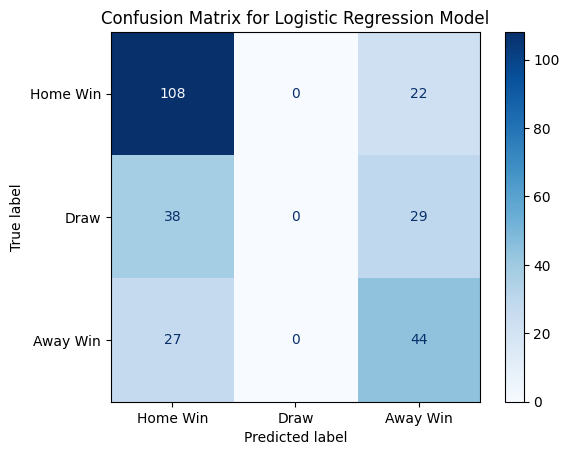

In [15]:
# Compute confusion matrix for logistic regression model
cm_logistic = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp_logistic = ConfusionMatrixDisplay(confusion_matrix=cm_logistic, display_labels=['Home Win', 'Draw', 'Away Win'])
disp_logistic.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()